In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange

import copy
from collections import namedtuple
import os
import random
import shutil
import time
import math

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
import cv2
import urllib
import requests
import PIL.Image
import numpy as np
from bs4 import BeautifulSoup


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir ="/content/drive/MyDrive/content2/train/"
test_dir ="/content/drive/MyDrive/content2/test/"
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)

print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')


In [ ]:
pretrained_size = 224
pretrained_means =[0.2308, 0.2719, 0.2373]
pretrained_stds= [0.0827, 0.1232, 0.0775]
train_dir ="/content/drive/MyDrive/content/train/"
test_dir ="/content/drive/MyDrive/content/test/"
train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])
test_data1 = datasets.ImageFolder(root = test_dir, transform = test_transforms)
train_data = datasets.ImageFolder(root = train_dir, transform = train_transforms)



In [ ]:
VALID_RATIO = 0.8

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

n_train_examples = int(len(train_data) * VALID_RATIO)

TEST_RATIO = 1 -0.22

n_train_examples = int(len(train_data) * TEST_RATIO)
n_test_examples = len(train_data) - n_train_examples

train_data, test_data = data.random_split(train_data,
                                           [n_train_examples, n_test_examples])

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

test_data = copy.deepcopy(test_data)
test_data.dataset.transform = test_transforms

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 346
Number of validation examples: 111
Number of testing examples: 98


In [ ]:
def plot_images(images, labels, classes, normalize=False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min=image_min, max=image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data1.classes

# plot_images(images, labels, classes)
# plot_images(images, labels, classes, normalize=True)

In [ ]:
BATCH_SIZE = 48

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

In [ ]:
# Create a DataFrame with random values'
No_of_classes=3
No_of_clusters=3
random_values = np.random.uniform(0,1,(No_of_classes, No_of_clusters))
cluster_matrix = (random_values)
print(cluster_matrix)


[[0.19151945 0.62210877 0.43772774]
 [0.78535858 0.77997581 0.27259261]
 [0.27646426 0.80187218 0.95813935]]


In [ ]:
def get_weights(y_pred, y, margin_parameter, decay_rate, learning_rate, epoch):
    random_val1 = np.zeros((No_of_classes, No_of_clusters),dtype=np.float64)
    cluster_matrix_delta = (random_val1)
    random_val2 = np.zeros((No_of_classes, No_of_clusters),dtype=np.float64)
    cluster_matrix_count = (random_val2)
    observation_weights=[]
    for yi in range(len(y)):
        label=int(y[yi])
        clusters = cluster_matrix[label]
        dis_from_obs_label=100000
        centre=0
        for i in range(len(clusters)):
            if dis_from_obs_label> math.sqrt((y_pred[yi][label]-clusters[i])**2):
                centre=i;
                dis_from_obs_label=min(dis_from_obs_label, math.sqrt((y_pred[yi][label]-clusters[i])**2))

        dis_from_other=100000

        for i in range(No_of_classes):
            for j in range(No_of_clusters):
                if(i==label):
                    continue
                new_cluster=cluster_matrix[i]
                for k in new_cluster:
                    dis_from_other=min(dis_from_other, math.sqrt((y_pred[yi][i]-k)**2))

        #violation factor
        violation=max(0, dis_from_obs_label-dis_from_other+margin_parameter)
        # print(violation)
        w=np.exp(-1*decay_rate*violation)
        if epoch < 150 : w = 1
        observation_weights.append(w)
        val = 1
        if y_pred[yi][label] > clusters[centre] : val = -1

        cluster_matrix_delta[label][int(centre)] += val * w
        cluster_matrix_count[label][int(centre)] +=1

    # loss = weighted_cross_entropy_loss(y, y_pred, observation_weights)
    #update the cluster centres
    for i in range(No_of_classes):
        for j in range(No_of_clusters):
            cluster_matrix[i][j] -= learning_rate*cluster_matrix_delta[i][j]/(1+cluster_matrix_count[i][j])


    return observation_weights

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),  # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2),  # kernel_size
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(50176, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

In [ ]:
OUTPUT_DIM = No_of_classes

model = AlexNet(OUTPUT_DIM)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 224,570,179 trainable parameters


In [ ]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=50176, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, i

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def noise_ratio(y,nr,device):
  new_y_with_nr = []
  for currlabel in y:
      u = np.random.uniform(0,1)
      newlabel = int(currlabel)

      if   u<=nr :
        newlabel = random.randint(0,OUTPUT_DIM-1)
        if newlabel == currlabel:
          newlabel += 1
          newlabel %= OUTPUT_DIM

      new_y_with_nr.append(int (newlabel/1))

  res = torch.tensor(new_y_with_nr,dtype=torch.long)
  res = res.to(device)
  return res

In [ ]:
def train(model, iterator, optimizer, criterion, device, nr=0):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)
        y_noise = noise_ratio(y,nr, device)
        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y_noise)

        acc = calculate_accuracy(y_pred, y_noise)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import matplotlib.pyplot as plt
import numpy
def check_point_fc( y_pred, y, device):
    y_pred_tmp = y_pred.cpu().detach().numpy()
    # y_pred = y_pred.to(device)
    import matplotlib.pyplot as plt
    lis = []

    for i in range(No_of_classes):
        l = []
        lis.append(l)

    for i in range(len(y)):
        label = int (y[i])
        lis[label].append(y_pred_tmp[i][label])

    counter_start = 1
    counter_end = len(lis[0])
    y = np.linspace(counter_start, counter_end, counter_end -counter_start + 1 )
    plt.scatter(lis[0], y, c='green')

    counter_start = counter_end + 1
    counter_end = counter_end + len(lis[1])
    y = np.linspace(counter_start, counter_end, counter_end -counter_start + 1 )
    plt.scatter(lis[1], y, c='red')

    counter_start = 1 + counter_end
    counter_end = len(lis[2]) + counter_end
    y = np.linspace(counter_start, counter_end, counter_end -counter_start + 1 )
    plt.scatter(lis[2], y, c='blue')
    plt.show()


In [ ]:
def train_with_decode(model, iterator, optimizer, criterion, device, nr=0):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)
        # Introducing noise in the images
        y_noise = noise_ratio( y, nr, device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        # if curr_epoch % 10 == 0 :
        #   check_point_fc( y_pred, y, device)

        observation_weights = torch.tensor(get_weights(y_pred, y_noise, 0, 0.05, 0.0005, epoch))
        criterion = nn.CrossEntropyLoss(reduction = 'none')

        LOSS = criterion(y_pred, y_noise)

        acc = calculate_accuracy(y_pred, y_noise)
        loss = 0.0
        for i in range(len(observation_weights)):
            loss += LOSS[i]*observation_weights[i]

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
optimizer = optim.Adam(model.parameters(), 0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot

def display_predictions(model, iterator, class_names, device, num_images=10, normalize=False):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(iterator))
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():  # Inference mode, gradient computations are off
        outputs = model(images)
        if isinstance(outputs, tuple):  # Handling models that return tuples
            outputs = outputs[0]
        _, predicted = torch.max(outputs, 1)

    images = images.cpu()  # Move images back to CPU for visualization
    predicted = predicted.cpu().numpy()  # Convert to NumPy array for indexing
    labels = labels.cpu().numpy()

    fig = plt.figure(figsize=(15, 9))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    counter = 0
    for i in range(min(num_images, len(images))):
        ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        image = images[i].numpy().transpose((1, 2, 0))  # Convert CHW to HWC

        if normalize:
            # Reverse the normalization
            image_min = image.min()
            image_max = image.max()
            image = (image - image_min) / (image_max - image_min + 1e-5)

        ax.imshow(image)
        ax.text(3, 15, f"True: {class_names[labels[i]]}", color='white', fontsize=14)
        if class_names[predicted[i]] == class_names[labels[i]]:
          ax.text(3, 34, f"Pred: {class_names[predicted[i]]}", color='blue', fontsize=14)
          counter += 1
        else:
          ax.text(3, 34, f"Pred: {class_names[predicted[i]]}", color='red', fontsize=14)
        ax.axis('off')

    # For percentage
    print(f'Correctly predicted images = {100 * counter/num_images:.2f}%')
    plt.show()

In [ ]:
EPOCHS = 25
curr_epoch = 0
best_valid_loss = float('inf')

# Define the directory where checkpoints are stored
checkpoint_dir = '/content/drive/MyDrive/checkpoints'
checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.pth')

# Initialize variables for tracking the best performance and current epoch
best_accuracy = 0.0
# curr_epoch = 0

# Check if checkpoint exists and load it
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    curr_epoch = checkpoint['epoch']
    best_accuracy = checkpoint['best_accuracy']
    print(f"Loaded checkpoint from epoch {curr_epoch}, with best accuracy {best_accuracy}.")
else:
    print("No checkpoint found. Starting training from scratch.")

model = model.to(device)



while curr_epoch <= EPOCHS:

    epoch = curr_epoch

    start_time = time.monotonic()

    train_loss, train_acc = train_with_decode(model, train_iterator, optimizer, criterion, device, 0.4)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')

    end_time = time.monotonic()
    curr_epoch += 1
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if True:
        print(f"Epoch {epoch}: New best model found.")
        best_accuracy = valid_acc
        checkpoint = {
            'epoch': epoch + 1,  # Saving next epoch index to continue from
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_accuracy': best_accuracy,
        }
        torch.save(checkpoint, checkpoint_path)



    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

No checkpoint found. Starting training from scratch.


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0: New best model found.
Epoch: 01 | Epoch Time: 6m 7s
	Train Loss: 12574.077 | Train Acc: 38.02%
	 Val. Loss: 1.960 |  Val. Acc: 17.50%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: New best model found.
Epoch: 02 | Epoch Time: 2m 27s
	Train Loss: 57.593 | Train Acc: 31.67%
	 Val. Loss: 1.070 |  Val. Acc: 38.75%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2: New best model found.
Epoch: 03 | Epoch Time: 2m 16s
	Train Loss: 47.429 | Train Acc: 39.43%
	 Val. Loss: 1.096 |  Val. Acc: 24.03%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3: New best model found.
Epoch: 04 | Epoch Time: 2m 21s
	Train Loss: 47.341 | Train Acc: 40.63%
	 Val. Loss: 1.037 |  Val. Acc: 66.81%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4: New best model found.
Epoch: 05 | Epoch Time: 2m 23s
	Train Loss: 47.291 | Train Acc: 41.93%
	 Val. Loss: 1.033 |  Val. Acc: 42.92%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5: New best model found.
Epoch: 06 | Epoch Time: 2m 29s
	Train Loss: 45.564 | Train Acc: 49.32%
	 Val. Loss: 1.015 |  Val. Acc: 50.69%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6: New best model found.
Epoch: 07 | Epoch Time: 2m 26s
	Train Loss: 44.490 | Train Acc: 50.99%
	 Val. Loss: 0.969 |  Val. Acc: 50.69%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7: New best model found.
Epoch: 08 | Epoch Time: 2m 21s
	Train Loss: 46.712 | Train Acc: 39.48%
	 Val. Loss: 1.022 |  Val. Acc: 50.00%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8: New best model found.
Epoch: 09 | Epoch Time: 2m 25s
	Train Loss: 46.093 | Train Acc: 44.90%
	 Val. Loss: 0.870 |  Val. Acc: 47.22%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9: New best model found.
Epoch: 10 | Epoch Time: 2m 20s
	Train Loss: 45.362 | Train Acc: 44.43%
	 Val. Loss: 1.021 |  Val. Acc: 46.53%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10: New best model found.
Epoch: 11 | Epoch Time: 2m 18s
	Train Loss: 46.295 | Train Acc: 42.34%
	 Val. Loss: 0.985 |  Val. Acc: 45.83%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11: New best model found.
Epoch: 12 | Epoch Time: 2m 15s
	Train Loss: 46.365 | Train Acc: 45.94%
	 Val. Loss: 0.956 |  Val. Acc: 67.50%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12: New best model found.
Epoch: 13 | Epoch Time: 2m 17s
	Train Loss: 47.530 | Train Acc: 47.86%
	 Val. Loss: 1.022 |  Val. Acc: 40.28%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13: New best model found.
Epoch: 14 | Epoch Time: 2m 15s
	Train Loss: 47.583 | Train Acc: 45.00%
	 Val. Loss: 1.024 |  Val. Acc: 32.50%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14: New best model found.
Epoch: 15 | Epoch Time: 2m 17s
	Train Loss: 46.624 | Train Acc: 39.17%
	 Val. Loss: 0.916 |  Val. Acc: 69.44%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15: New best model found.
Epoch: 16 | Epoch Time: 2m 20s
	Train Loss: 45.524 | Train Acc: 50.21%
	 Val. Loss: 0.958 |  Val. Acc: 67.50%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16: New best model found.
Epoch: 17 | Epoch Time: 2m 19s
	Train Loss: 44.673 | Train Acc: 48.70%
	 Val. Loss: 0.872 |  Val. Acc: 67.50%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17: New best model found.
Epoch: 18 | Epoch Time: 2m 19s
	Train Loss: 45.975 | Train Acc: 44.79%
	 Val. Loss: 0.859 |  Val. Acc: 68.19%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18: New best model found.
Epoch: 19 | Epoch Time: 2m 23s
	Train Loss: 43.301 | Train Acc: 52.50%
	 Val. Loss: 0.834 |  Val. Acc: 67.50%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19: New best model found.
Epoch: 20 | Epoch Time: 2m 16s
	Train Loss: 45.827 | Train Acc: 43.59%
	 Val. Loss: 0.859 |  Val. Acc: 71.11%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20: New best model found.
Epoch: 21 | Epoch Time: 2m 15s
	Train Loss: 43.936 | Train Acc: 47.19%
	 Val. Loss: 0.841 |  Val. Acc: 69.58%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21: New best model found.
Epoch: 22 | Epoch Time: 2m 18s
	Train Loss: 43.481 | Train Acc: 51.35%
	 Val. Loss: 0.834 |  Val. Acc: 71.11%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22: New best model found.
Epoch: 23 | Epoch Time: 2m 17s
	Train Loss: 45.405 | Train Acc: 43.07%
	 Val. Loss: 0.836 |  Val. Acc: 70.28%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23: New best model found.
Epoch: 24 | Epoch Time: 2m 18s
	Train Loss: 47.714 | Train Acc: 41.67%
	 Val. Loss: 0.914 |  Val. Acc: 71.11%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24: New best model found.
Epoch: 25 | Epoch Time: 2m 16s
	Train Loss: 45.264 | Train Acc: 44.69%
	 Val. Loss: 0.915 |  Val. Acc: 72.36%


Training:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25: New best model found.
Epoch: 26 | Epoch Time: 2m 16s
	Train Loss: 44.537 | Train Acc: 46.09%
	 Val. Loss: 0.882 |  Val. Acc: 72.36%


Correctly predicted images = 70.00%


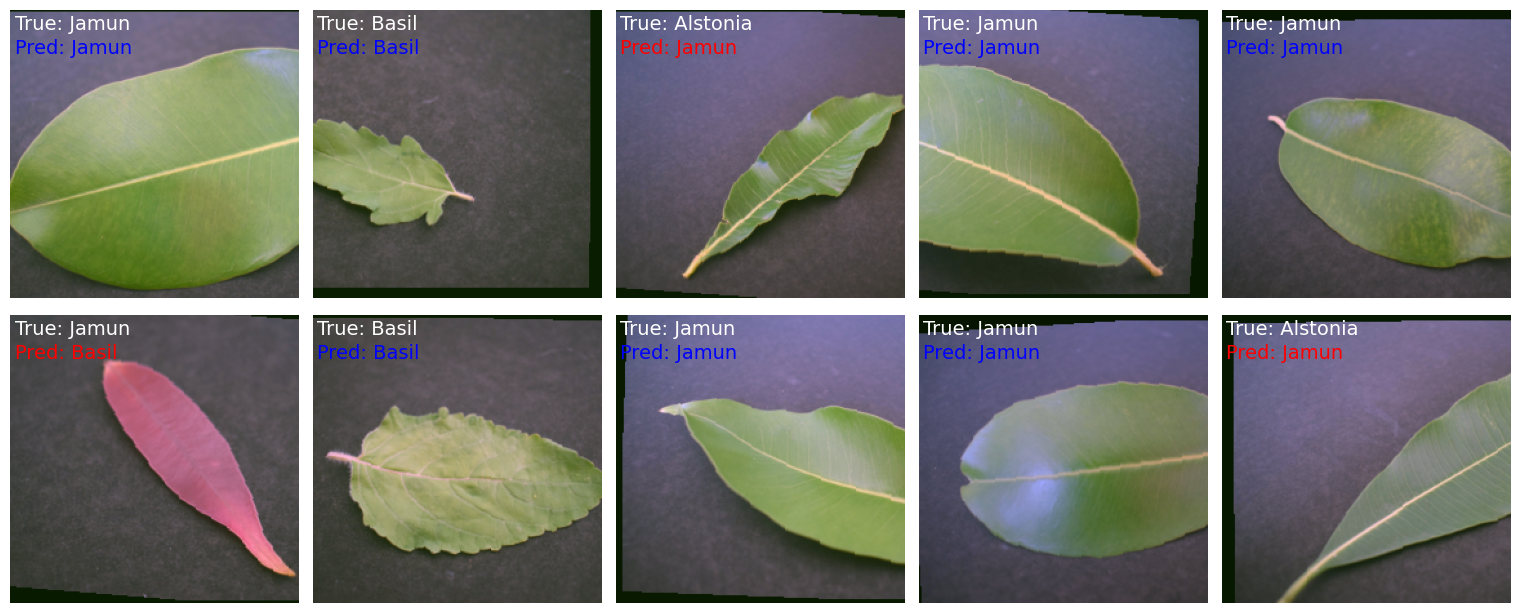

In [ ]:
class_names = ['Alstonia','Basil', 'Jamun']
display_predictions(model, test_iterator, class_names, device, normalize=True)

In [ ]:
from tqdm import tqdm

def evaluate_test_data(model, test_iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in tqdm(test_iterator, desc="Testing", leave=False):
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc  # Removed .item()

    return epoch_loss / len(test_iterator), epoch_acc / len(test_iterator)

# Now, you can call this function for the test data loader
test_loss, test_accuracy = evaluate_test_data(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_accuracy*100:.2f}%')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Original noise ratios and test accuracies
noise_ratios_float = np.array([0, 0.1, 0.2, 0.3, 0.4])
test_accuracy_without_decode = np.array([91.67, 86.33,83.3,76.53, 71.53, 69.88, 65.97, 58.89, 45.28])
test_accuracy_with_decode = np.array([91.67,91.48, 90.97, 84.68, 80.56,79.79, 79.01,72.61, 65.36])

# New noise ratios for interpolation
new_noise_ratios = np.arange(0, 0.45, 0.05)

# Interpolating test accuracies to the new noise ratios
interp_accuracy_without_decode = np.interp(new_noise_ratios, noise_ratios_float, test_accuracy_without_decode)
interp_accuracy_with_decode = np.interp(new_noise_ratios, noise_ratios_float, test_accuracy_with_decode)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(new_noise_ratios, interp_accuracy_without_decode, marker='o', linestyle='-', linewidth=2, label='Without Decode')
plt.plot(new_noise_ratios, interp_accuracy_with_decode, marker='o', linestyle='-', linewidth=2, label='With Decode',color='green')

# Annotate each marker with its accuracy value
for i, txt in enumerate(interp_accuracy_without_decode):
    plt.annotate(f'{txt:.2f}%', (new_noise_ratios[i], interp_accuracy_without_decode[i]), textcoords="offset points", xytext=(0,10), ha='center')
for i, txt in enumerate(interp_accuracy_with_decode):
    plt.annotate(f'{txt:.2f}%', (new_noise_ratios[i], interp_accuracy_with_decode[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Test Accuracy vs. Noise Ratio')
plt.xlabel('Noise Ratio')
plt.ylabel('Test Accuracy (%)')
plt.xticks(new_noise_ratios)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()